# Graph Convolutional Networks

In this notebook, we will discuss the intuition behind graph convolutional networks (GCN).

In [1]:
import math
import numpy as np
import scipy

import matplotlib.pyplot as plt
import networkx as nx

Let $G=(V,E)$ be a graph with $n$ nodes, i.e. $V$ is a set of nodes $V=\{v_1, \dotsc, v_n\}$ and $E$ is a set of edges, i.e. $E\subseteq \{\{v, w\}\,\vert\, v, w\in V\}$. To simplify the notation, we often denote the nodes with natural numbers and edges with pairs of natural numbers, i.e. $V=\{1, \dotsc, n\}$ and $E\subseteq \{\{i, j\}\,\vert\, i, j\in V\}$. We also can describe a graph as a list of edges. Let's have a look on a small example.

In [2]:
edge_list = np.array([
    [1, 2],
    [2, 3],
    [3, 4],
    [3, 5]
])

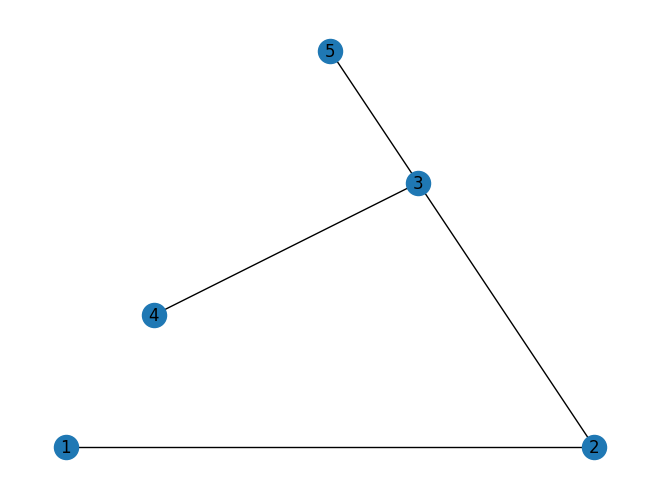

In [3]:
G = nx.from_edgelist(edge_list)

pos = nx.planar_layout(G)

nx.draw(G, pos, with_labels=True)

To each node $v\in V$ we assign a feature vector $x_v\in\mathbb{R}^d$, which will be used as input for our model. We can gather these feature vectors in the matrix $X\in\mathbb{R}^{n\times d}$, i.e. each row is a feature vector of a node. As example each of the five nodes get a four dimensional feature vector.

In [4]:
FEATURE_DIMENSION = 4

X = np.random.rand(5, FEATURE_DIMENSION)

X

array([[0.65075655, 0.79535875, 0.71579676, 0.50376041],
       [0.19109517, 0.01538404, 0.65409261, 0.70677271],
       [0.58207986, 0.12598652, 0.05221181, 0.0767254 ],
       [0.89056242, 0.10394152, 0.35669619, 0.58237205],
       [0.78899457, 0.90985754, 0.03400964, 0.18196712]])

Further more, we can represent the graph $G$ as matrix. Indeed, the adjacency matrix $A\in\mathbb{R}^{n\times n}$ is defined as

$$
A_{ij} = \begin{cases}
    1 \text{ if } \{v_i, v_j\}\in E,\\
    0 \text{ else.}
\end{cases}
$$

In [5]:
def calculate_adjacency_matrix(edge_list: np.ndarray) -> np.ndarray:
    nodes = np.unique(edge_list)
    node_to_idx = {node: idx for idx, node in enumerate(nodes)}

    adj_matrix = np.zeros((len(nodes), len(nodes)))

    for edge in edge_list:
        node_idx_1 = node_to_idx[edge[0]]
        node_idx_2 = node_to_idx[edge[1]]

        adj_matrix[node_idx_1][node_idx_2] = 1
        adj_matrix[node_idx_2][node_idx_1] = 1

    return adj_matrix

In [6]:
A = calculate_adjacency_matrix(edge_list)

A

array([[0., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In a graph convolutional network we iteratively want to update the node representations by exchanging information with their neighbours. The neighbourhood of a node $i$ is defined as the set of nodes $j$, which are connected to $i$, i.e.
$$
    N_i = \{j \,\vert\, \{i, j\}\in E\}.
$$
The update of the representations is based on message passing, i.e. we have an aggregation step and an update step.

The aggregation $\overline{x_i}$ of node $i\in V$ is the sum of the representations of the neighbours of $i$, i.e.
$$
    \overline{x_i} = \sum_{j\in N_i}x_j = \sum_{j=1}^n a_{ij}x_j.
$$
In other words, the aggregated representation is the $i$-th row of $AX$.

One issue of this approach is that the aggregation of node $i$ does not take into account the representation of itself, i.e. we want to update the representation of $i$ with
$$
    x_i + \sum_{j\in N_i}x_j.
$$
To fix this, we add self-connections, i.e. each node is connected to itself. The adjacency matrix changes as follows: $\tilde{A} = A + I$, where $I\in\mathbb{R}^{n\times n}$ is the identity matrix.

In [7]:
A_tilde = A + np.eye(len(A))

A_tilde

array([[1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 0., 1.]])

Another issue is that nodes with large neighbourhoods get representation vectors with large magnitude. In contrast, nodes with only a few neighbours get representation vectors with a small magnitude. This can be a problem when searching for signals that are independent of the number of nodes. Also, this can lead to numerical stability issues. To fix this, we normalize the aggregated representation by the neighbourhood size, i.e.
$$
    \overline{x_i} = \frac{1}{\vert N_i\vert}\sum_{j\in Ni}x_j.
$$
We also can achieve this with a manipulated adjacency matrix. For that, we define the degree matrix of the graph. Let $\deg v$ be the number of neighbours of $v$, i.e. $\deg v = \vert N_v\vert$. Then we define the degree matrix $\tilde{D}$ of $\tilde{A}$ as $\tilde{D} = \operatorname{diag}(\deg(v_i))_{i=1,\dotsc, n}$. In other words, it holds $\tilde{d}_{ii} = \sum_{j=1}^n\tilde{a}_{ij}$.

Since each node is at least connected to itself, this means that all node degrees are positive and hence $\tilde{D}$ is invertible. The matrix product $\tilde{D}^{-1}A$ normalizes the aggregated representation, i.e. $\overline{x_i}$ is the $i$-th row of $\tilde{D}^{-1}AX$.

In [8]:
def calculate_degree_matrix(adj_matrix: np.ndarray) -> np.ndarray:
    node_degrees = np.sum(adj_matrix, axis=0)

    return np.diag(node_degrees)

In [9]:
D_tilde = calculate_degree_matrix(A_tilde)

D_tilde

array([[2., 0., 0., 0., 0.],
       [0., 3., 0., 0., 0.],
       [0., 0., 4., 0., 0.],
       [0., 0., 0., 2., 0.],
       [0., 0., 0., 0., 2.]])

In [10]:
np.linalg.inv(D_tilde) @ A_tilde

array([[0.5       , 0.5       , 0.        , 0.        , 0.        ],
       [0.33333333, 0.33333333, 0.33333333, 0.        , 0.        ],
       [0.        , 0.25      , 0.25      , 0.25      , 0.25      ],
       [0.        , 0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.        , 0.5       , 0.        , 0.5       ]])

There is still a problem left: nodes with many neighbours can share their information more easily than nodes with only a few neighbours. Therefore, we also normalize by the source node degree. We achieve this by defining
$$
    \hat{A} = \tilde{D}^{-1/2}A\tilde{D}^{-1/2}.
$$
Elementwise we see that $\hat{a}_{ij} = \frac{1}{\sqrt{\tilde{d_i}\tilde{d_j}}}\tilde{a}_{ij}$ holds.

For the aggregated of the representation it follows that
$$
    \overline{x_i} = \sum_{j\in N_i}\frac{1}{\sqrt{\tilde{d_i}\tilde{d_j}}}x_j = \frac{1}{\sqrt{\tilde{d_i}}}\sum_{j\in N_i}\frac{1}{\sqrt{\tilde{d_j}}}x_j.
$$

In [11]:
D_invroot = np.linalg.inv(scipy.linalg.sqrtm(D_tilde))

D_invroot

array([[0.70710678, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.57735027, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.70710678, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.70710678]])

In [12]:
A_hat = D_invroot @ A_tilde @ D_invroot

A_hat

array([[0.5       , 0.40824829, 0.        , 0.        , 0.        ],
       [0.40824829, 0.33333333, 0.28867513, 0.        , 0.        ],
       [0.        , 0.28867513, 0.25      , 0.35355339, 0.35355339],
       [0.        , 0.        , 0.35355339, 0.5       , 0.        ],
       [0.        , 0.        , 0.35355339, 0.        , 0.5       ]])

We have seen above that we can calculate $\hat{A}$ directly by using $\hat{a}_{ij} = \frac{1}{\sqrt{\tilde{d_i}\tilde{d_j}}}\tilde{a}_{ij}$.

In [13]:
def calculate_A_hat(adj_matrix: np.ndarray) -> np.ndarray:
    degrees = np.sum(adj_matrix, axis=0)
    degree_roots = [math.sqrt(degree) for degree in degrees]

    n = len(adj_matrix)

    A_hat = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            A_hat[i][j] = adj_matrix[i][j] / (degree_roots[i] * degree_roots[j])

    return A_hat

In [14]:
calculate_A_hat(A_tilde)

array([[0.5       , 0.40824829, 0.        , 0.        , 0.        ],
       [0.40824829, 0.33333333, 0.28867513, 0.        , 0.        ],
       [0.        , 0.28867513, 0.25      , 0.35355339, 0.35355339],
       [0.        , 0.        , 0.35355339, 0.5       , 0.        ],
       [0.        , 0.        , 0.35355339, 0.        , 0.5       ]])

We update the representations by multiplying the aggregated results with the trainable weight matrix $W\in\mathbb{R}^{d\times w}$, i.e. we are interested in the product $\hat{A}XW$. Also, we apply a non-linear activation function $\sigma$ (e.g. ReLU) to the product, i.e. we define

$$
    f_W(X, A) = \sigma(\hat{A}XW).
$$
We call this a graph convolutional layer.

In [15]:
W = np.random.rand(FEATURE_DIMENSION, 2)

W

array([[0.68224617, 0.02770412],
       [0.43337131, 0.37158243],
       [0.04090132, 0.51271641],
       [0.05296721, 0.06834341]])

In [16]:
A_hat @ X @ W

array([[0.50446261, 0.51862626],
       [0.54408216, 0.4508674 ],
       [0.7529945 , 0.37660332],
       [0.51093124, 0.17656146],
       [0.63371123, 0.22848079]])

In [17]:
def ReLU(x: np.ndarray) -> np.ndarray:
    return np.maximum(x, 0)

In [18]:
ReLU(A_hat @ X @ W)

array([[0.50446261, 0.51862626],
       [0.54408216, 0.4508674 ],
       [0.7529945 , 0.37660332],
       [0.51093124, 0.17656146],
       [0.63371123, 0.22848079]])

Until now we only considered the direct neighbours of a node, but nodes that are further away could also be of interest. By stacking multiple graph convolutional layers the information from a single node can spread further in the graph, i.e. if we stack $n$ layers the nodes which are at max $n$ hops away will be taken into account. We can define the $n$ layer like this:

$$
    H_1\coloneqq f_{W_1}(X, A) \\
    H_2\coloneqq f_{W_2}(H_1, A) \\
    \vdots \\
    H_n\coloneqq f_{W_n}(H_{n-1}, A) \\
$$

## Water drop

In [19]:
x = np.array([1, 0, 0, 0, 0])

results = [x]

for _ in range(11):
    x = A_hat @ x
    results.append(x)

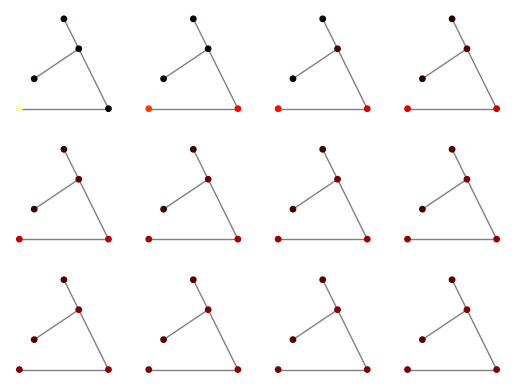

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=4)

kwargs = {
    "cmap": "hot",
    "node_size": 15,
    "edge_color": "gray",
    "vmin": np.array(results).min(),
    "vmax": np.array(results).max() * 1.1
}

for index, result in enumerate(results):
    nx.draw(G, pos, node_color=result, ax=ax[index // 4][index % 4], **kwargs)